In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyp

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

In [3]:
envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

In [4]:
Phi_spheroid = plummer_potential

theta_spheroid = jnp.array([1e12, 10000.0]) # (M, a) z.B. für Plummer

In [5]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law as df_spheroid
candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

Number of candidate actions: 500000


In [6]:
jnp.sum(soft_weights)

Array(3450.7158, dtype=float32)

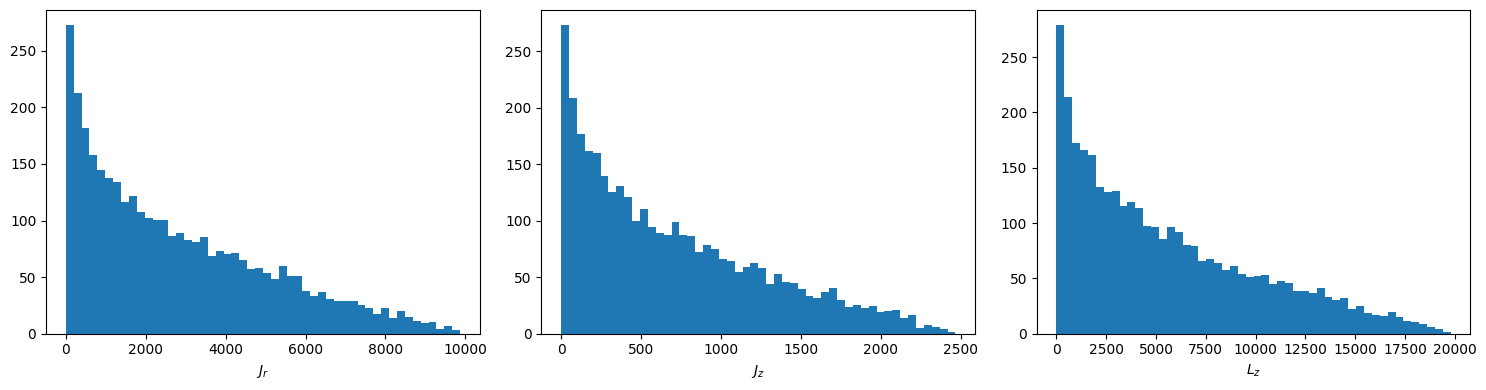

In [7]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

In [8]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)

Phase-space coordinates shape: (500000, 6)


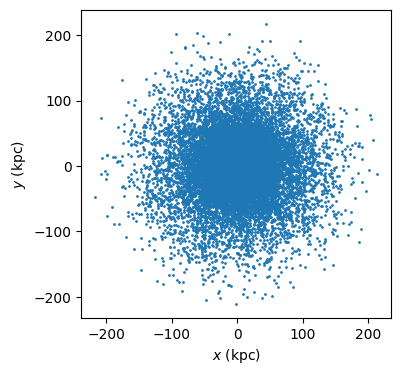

In [9]:
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

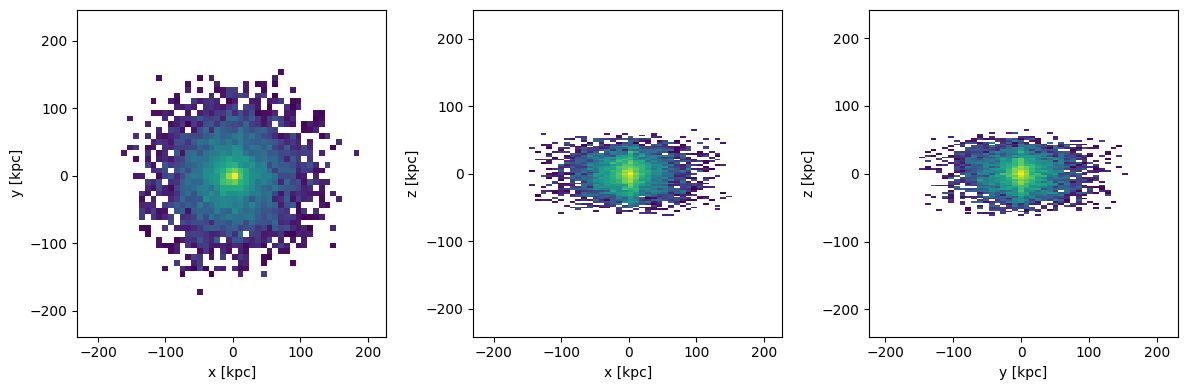

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

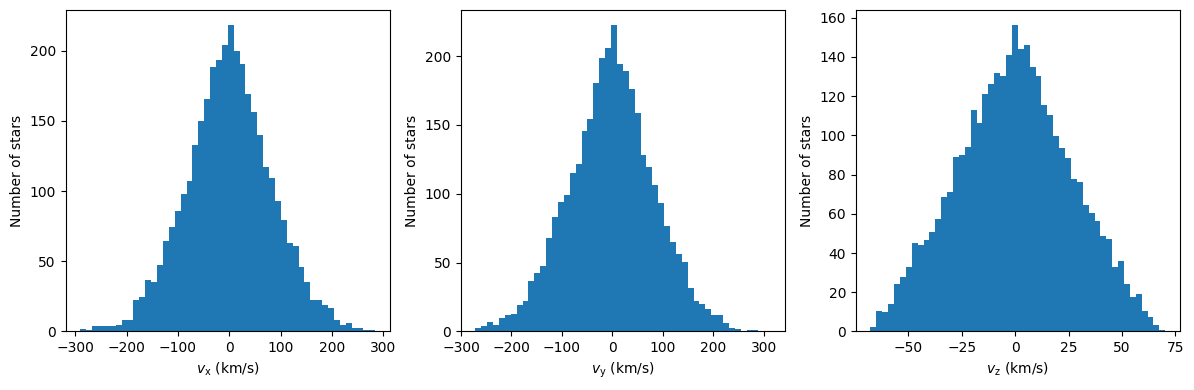

In [11]:
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

R = jnp.sqrt(x**2 + y**2)
mask = R > 0.0
v_x_masked = v_x[mask]
v_y_masked = v_y[mask]
v_z_masked = v_z[mask]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(v_x_masked, bins=50, weights=soft_weights[mask])#, range=(-500, 500))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")


plt.subplot(1,3,2)
plt.hist(v_y_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(1,3,3)
plt.hist(v_z_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

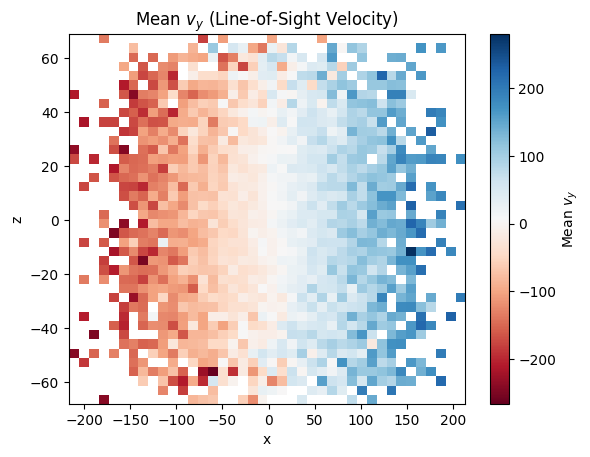

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y[mask], weights=soft_weights[mask])

# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu') #, vmin=-10000, vmax=10000)#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

In [13]:
import jax
import jax.numpy as jnp

def compute_density_jax(x, y, z, weights, theta_spheroid, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)
    weights = weights / jnp.sum(weights)*theta_spheroid[0]  # Normalize weights

    # 2. Use histogram2d to accumulate weights efficiently
    # This replaces the entire fori_loop and digitize logic
    counts, _, _ = jnp.histogram2d(
        r, z, 
        bins=[r_bins, z_bins], 
        weights=weights
    )

    # 3. Compute the volume of each bin
    # Use midpoint r for volume calculation to be more accurate
    r_mid = (r_bins[:-1] + r_bins[1:]) / 2
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    
    # Calculate volume of cylindrical shell: V = 2 * pi * r * dr * dz
    bin_volumes = 2 * jnp.pi * jnp.outer(r_mid * r_widths, z_widths)

    # 4. Normalize
    density = counts / bin_volumes
    
    return density

In [14]:
density = compute_density_jax(x, y, z, soft_weights, theta_spheroid, r_bins=jnp.linspace(0.1, 10, 20), z_bins=jnp.linspace(-5, 5, 20))

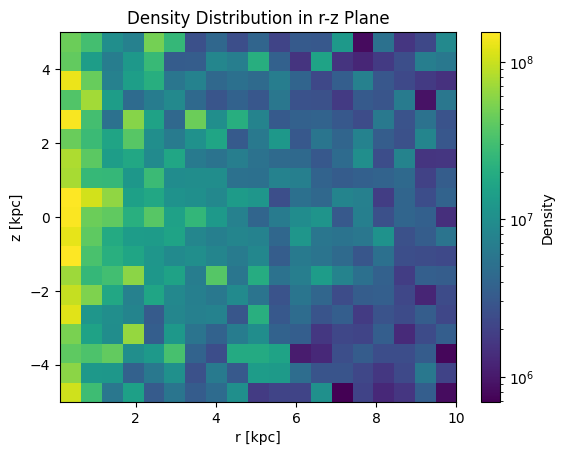

In [15]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Density Distribution in r-z Plane')
plt.show()

In [16]:
import jax
import jax.numpy as jnp

def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2

    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid


In [17]:
r_bins = jnp.linspace(0.1, 5, 20) # Avoid 0 if potential has singularity at origin
z_bins = jnp.linspace(-5, 5, 20)

# JIT Compile
#jit_laplacian = jax.jit(compute_laplacian_on_grid)

# Run
#nabla2_Phi = jit_laplacian(r_bins, z_bins, theta)

nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_spheroid, r_bins, z_bins)

print("Laplacian shape:", nabla2_Phi.shape)

Laplacian shape: (19, 19)


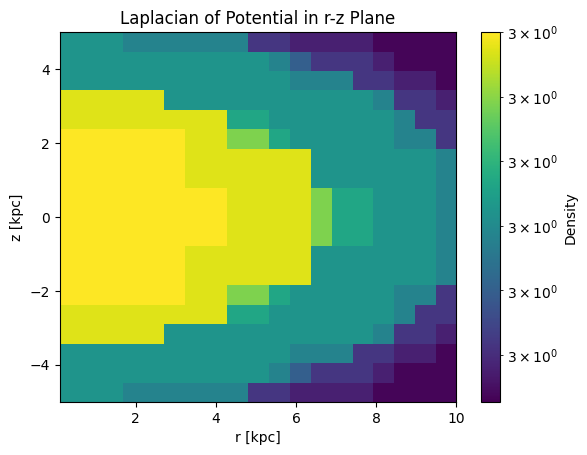

In [18]:
plt.imshow(nabla2_Phi.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Laplacian of Potential in r-z Plane')
plt.show()

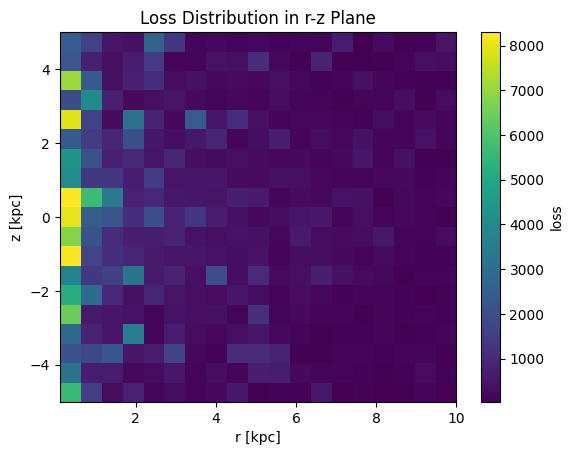

In [19]:
#G = 1e-11
G=4.30091e-6  # in (kpc^2/solar mass)*(1/s)^2
lossplane = (4*jnp.pi*G*density - nabla2_Phi)
#mask = density > 0
#lossplane = lossplane * mask

plt.imshow(lossplane.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()

In [20]:
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
from numpy.lib.stride_tricks import as_strided

r_bins = jnp.linspace(0.1, 5, 20) # Avoid 0 if potential has singularity at origin
z_bins = jnp.linspace(-5, 5, 20)

def compute_kde_density_jax(x, y, z, weights, theta_spheroid, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)
    weights = weights / jnp.sum(weights)*theta_spheroid[0]  # Normalize weights

    
    # 2. Stack r and z for KDE input
    data = jnp.vstack([r, z])

    # 2a. Repeat data points based on integer weights
    #weighted_r = jnp.repeat(r, weights)
    #weighted_z = jnp.repeat(z, weights)
    #weighted_data = jnp.stack([weighted_r, weighted_z])

    # 3. Compute KDE
    kde = gaussian_kde(data, weights=weights)

    # 4. Create grid for evaluation
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_points = jnp.vstack([R_grid.ravel(), Z_grid.ravel()])

    # 5. Evaluate KDE on grid
    density_values = kde(grid_points)

    # 6. Reshape back to grid shape
    density_grid = density_values.reshape(R_grid.shape)

    return density_grid

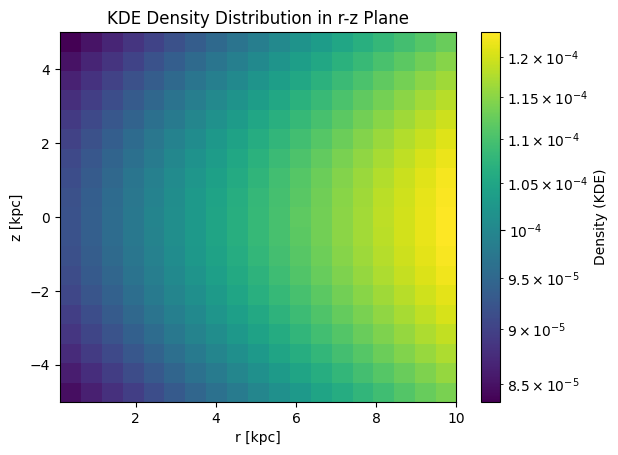

In [21]:
density_kde = compute_kde_density_jax(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins)

plt.imshow(density_kde.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density (KDE)')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('KDE Density Distribution in r-z Plane')
plt.show()

In [22]:
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde

# Define a default, smaller bandwidth array
# Example: Use 5 times smaller than the average bin width, or based on the data span
def compute_kde_density_physical_tuned(x, y, z, weights, theta_spheroid, r_bins, z_bins, bandwidth=None):
    
    # ... (Steps 1, 2, 3: Filtering, r, data, and weight setup remain the same) ...
    is_finite = jnp.isfinite(x) & jnp.isfinite(y) & jnp.isfinite(z) & jnp.isfinite(weights)
    x, y, z, weights = x[is_finite], y[is_finite], z[is_finite], weights[is_finite]
    if x.size == 0:
        return jnp.zeros((len(r_bins) - 1, len(z_bins) - 1))
    total_target_weight = jnp.sum(weights) * theta_spheroid[0]
    weights_for_kde = weights / jnp.sum(weights)
    r = jnp.sqrt(x**2 + y**2)
    data = jnp.vstack([r, z])

    # --- NEW: Bandwidth Selection ---
    if bandwidth is None:
        # Calculate a reasonable default based on the scale of the data and grid
        # The scale of r is 5, scale of z is 10. Let's use 1/10th of the range as a start.
        r_range = jnp.max(r) - jnp.min(r)
        z_range = jnp.max(z) - jnp.min(z)
        # Using a fixed small value often works better for highly non-Gaussian data
        h_r = 0.5 * (r_bins[1] - r_bins[0]) # Start with half the radial bin width
        h_z = 0.5 * (z_bins[1] - z_bins[0]) # Start with half the vertical bin width
        bandwidth = jnp.array([h_r, h_z]) 

    # 4. Compute KDE, passing the manual bandwidth
    # The 'bw_method' argument can accept a scalar or a list/array for the bandwidth
    kde = gaussian_kde(data, weights=weights_for_kde)
    
    # ... (Steps 5, 6, 7: Grid evaluation, cylindrical normalization, and final scaling) ...

    # 5. Create grid and evaluate
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_points = jnp.vstack([R_grid.ravel(), Z_grid.ravel()])
    density_area = kde(grid_points).reshape(R_grid.shape)

    # 6. Apply Cylindrical Normalization
    R_grid_safe = jnp.where(R_grid > 1e-6, R_grid, 1e-6)
    unnorm_physical_density = density_area / (2 * jnp.pi * R_grid_safe)

    # 7. Final Normalization
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    bin_volumes = 2 * jnp.pi * jnp.outer(r_centers * r_widths, z_widths)
    total_kde_weight = jnp.sum(unnorm_physical_density * bin_volumes)
    density_physical = unnorm_physical_density * (total_target_weight / total_kde_weight)

    return density_physical

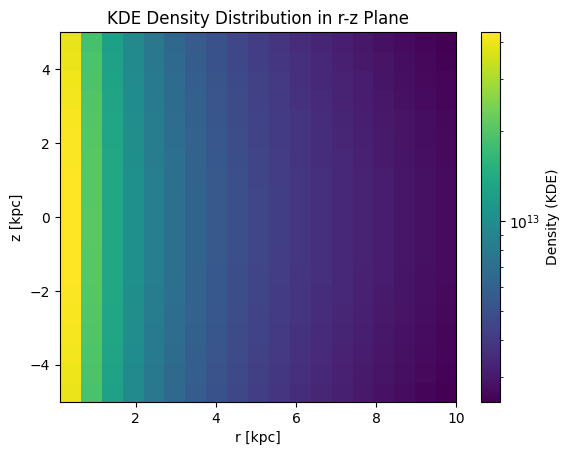

In [23]:
density_kde2 = compute_kde_density_physical_tuned(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins)

plt.imshow(density_kde2.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density (KDE)')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('KDE Density Distribution in r-z Plane')
plt.show()

In [24]:
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde

# Define the function to allow custom bandwidths via arguments
def compute_kde_density_physical_anisotropic(x, y, z, weights, theta_spheroid, r_bins, z_bins, bandwidth_r=None, bandwidth_z=None):
    
    # 1. Input Filtering, r, data, and weight setup (Same as before)
    is_finite = jnp.isfinite(x) & jnp.isfinite(y) & jnp.isfinite(z) & jnp.isfinite(weights)
    x, y, z, weights = x[is_finite], y[is_finite], z[is_finite], weights[is_finite]
    if x.size == 0:
        return jnp.zeros((len(r_bins) - 1, len(z_bins) - 1))
    total_target_weight = jnp.sum(weights) * theta_spheroid[0]
    weights_for_kde = weights / jnp.sum(weights)
    r = jnp.sqrt(x**2 + y**2)
    data = jnp.vstack([r, z])

    # 2. Instantiate KDE with a dummy isotropic bandwidth (e.g., 'scott')
    # This is necessary because JAX requires a valid scalar bw_method argument in __init__
    kde = gaussian_kde(data, bw_method='scott', weights=weights_for_kde)

    # 3. --- CRITICAL: Manually Set Anisotropic Bandwidth ---
    
    # Define h_r and h_z based on bin widths if not provided (best starting point)
    if bandwidth_r is None:
        bandwidth_r = 0.5 * (r_bins[1] - r_bins[0]) 
    if bandwidth_z is None:
        bandwidth_z = 0.5 * (z_bins[1] - z_bins[0])
        
    # Construct the desired Anisotropic Covariance Matrix (H = diag([h_r^2, h_z^2]))
    desired_covariance = jnp.diag(jnp.array([bandwidth_r**2, bandwidth_z**2]))
    
    # Override the KDE object's internal covariance and inverse covariance
    # This forces the KDE to use the custom, unequal smoothing in r and z.
    kde.covariance = desired_covariance
    kde.inv_cov = jnp.linalg.inv(desired_covariance)
    
    # 4. Grid Evaluation and Transformation (Same as before)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_points = jnp.vstack([R_grid.ravel(), Z_grid.ravel()])
    density_area = kde(grid_points).reshape(R_grid.shape)

    # 5. Apply Cylindrical Normalization (Jacobian: 1 / (2 * pi * r))
    R_grid_safe = jnp.where(R_grid > 1e-6, R_grid, 1e-6)
    unnorm_physical_density = density_area / (2 * jnp.pi * R_grid_safe)

    # 6. Final Normalization
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    bin_volumes = 2 * jnp.pi * jnp.outer(r_centers * r_widths, z_widths)
    total_kde_weight = jnp.sum(unnorm_physical_density * bin_volumes)
    density_physical = unnorm_physical_density * (total_target_weight / total_kde_weight)

    return density_physical

In [25]:
density_kde2 = compute_kde_density_physical_anisotropic(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins)

plt.imshow(density_kde2.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density (KDE)')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('KDE Density Distribution in r-z Plane')
plt.show()

FrozenInstanceError: cannot assign to field 'covariance'

In [60]:
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
from jax import vmap

# Helper function to compute the Gaussian kernel, highly efficient in JAX
def _gaussian_kernel(x, x_i, H_inv, det_H):
    """Computes the density of a single Gaussian kernel."""
    d = x - x_i
    # Compute the quadratic form: -0.5 * d.T @ H_inv @ d
    exponent = -0.5 * jnp.einsum('i,ij,j->', d, H_inv, d)
    
    # Normalization factor: 1 / sqrt(det(2*pi*H))
    norm_factor = 1.0 / jnp.sqrt(det_H * (2 * jnp.pi)**2)
    
    return norm_factor * jnp.exp(exponent)

# Final function that is fully JAX-compliant and differentiable
def compute_kde_density_differentiable(x, y, z, weights, theta_spheroid, r_bins, z_bins, bandwidth_r=0.1, bandwidth_z=0.1):
    
    # 1. Input Filtering, r, data, and weight setup
    #is_finite = jnp.isfinite(x) & jnp.isfinite(y) & jnp.isfinite(z) & jnp.isfinite(weights)
    #x, y, z, weights = x[is_finite], y[is_finite], z[is_finite], weights[is_finite]
    #if x.size == 0:
    #    return jnp.zeros((len(r_bins) - 1, len(z_bins) - 1))
        
    total_target_weight = jnp.sum(weights) * theta_spheroid[0]
    # For this manual method, it's easier to keep weights unnormalized initially
    x = x + 1e-12 * jnp.random.normal(key, x.shape) # Add tiny noise
    y = y + 1e-12 * jnp.random.normal(key, y.shape) # Add tiny noise 
    r = jnp.sqrt(x**2 + y**2)
    data = jnp.vstack([r, z]).T # Shape: (N, 2)

    # 2. Define Anisotropic Bandwidth Matrix H (The Differentiable Component)
    if bandwidth_r is None:
        # Default starting point: half the bin width
        bandwidth_r = 0.5 * (r_bins[1] - r_bins[0])
    if bandwidth_z is None:
        bandwidth_z = 0.5 * (z_bins[1] - z_bins[0])

    # H is the Covariance Matrix: [[h_r^2, 0], [0, h_z^2]]
    H = jnp.diag(jnp.array([bandwidth_r**2, bandwidth_z**2]))
    H_inv = jnp.linalg.inv(H)
    det_H = jnp.linalg.det(H)

    # 3. Create Grid Points for Evaluation (x_eval)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_points = jnp.vstack([R_grid.ravel(), Z_grid.ravel()]).T # Shape: (M*K, 2)

    # 4. Compute Density on the Grid using vmap (Vectorization)
    
    # This vmap calculates the kernel density for *all* grid points (x) 
    # for *all* data points (x_i) and sums them up.
    
    # The inner function computes the density at one grid point (x)
    def compute_density_at_x(x_eval):
        # The inner vmap computes the kernel for all data points (x_i) at x_eval
        # The result is N density contributions
        kernel_contributions = vmap(
            lambda x_i: _gaussian_kernel(x_eval, x_i, H_inv, det_H)
        )(data)
        
        # Sum the weighted contributions to get the total area density
        return jnp.sum(weights * kernel_contributions)

    # The outer vmap applies the inner function to all grid points
    density_area_flat = vmap(compute_density_at_x)(grid_points)
    density_area = density_area_flat.reshape(R_grid.shape) # P / drdz

    # 5. Apply Cylindrical Normalization
    #R_grid_safe = jnp.where(R_grid > 1e-6, R_grid, 1e-6)
    epsilon = 1e-6 
    R_grid_safe = jnp.sqrt(R_grid**2 + epsilon**2) 
    unnorm_physical_density = density_area / (2 * jnp.pi * R_grid_safe)
    #unnorm_physical_density = density_area / (2 * jnp.pi * R_grid)

    # 6. Final Normalization (Scale to total_target_weight)
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    bin_volumes = 2 * jnp.pi * jnp.outer(r_centers * r_widths, z_widths)
    total_kde_weight = jnp.sum(unnorm_physical_density * bin_volumes)
    density_physical = unnorm_physical_density * (total_target_weight / total_kde_weight)

    return density_physical

In [72]:
import jax
import jax.numpy as jnp
from jax import vmap

# Helper function _gaussian_kernel remains the same...

def compute_kde_density_differentiable_final(
    x, y, z, weights, theta_spheroid, r_bins, z_bins, 
    key, # <-- NEW: Accept the PRNG key
    bandwidth_r=None, bandwidth_z=None
):
    
    # 1. Input Filtering, r, data, and weight setup (Data Jitter)
    is_finite = jnp.isfinite(x) & jnp.isfinite(y) & jnp.isfinite(z) & jnp.isfinite(weights)
    x, y, z, weights = x[is_finite], y[is_finite], z[is_finite], weights[is_finite]
    if x.size == 0:
        return jnp.zeros((len(r_bins) - 1, len(z_bins) - 1))
        
    total_target_weight = jnp.sum(weights) * theta_spheroid[0]
    
    # --- FIX 1: Split Key for Randomness ---
    key_x, key_y = jax.random.split(key) 

    # --- FIX 2: Use jax.random.normal ---
    # Add tiny noise (jitter) for differentiability at x=y=0 singularity
    x = x + 1e-12 * jax.random.normal(key_x, x.shape) 
    y = y + 1e-12 * jax.random.normal(key_y, y.shape) 
    
    r = jnp.sqrt(x**2 + y**2)
    data = jnp.vstack([r, z]).T

    # 2. Define Anisotropic Bandwidth Matrix H
    if bandwidth_r is None:
        bandwidth_r = 0.5 * (r_bins[1] - r_bins[0])
    if bandwidth_z is None:
        bandwidth_z = 0.5 * (z_bins[1] - z_bins[0])

    H = jnp.diag(jnp.array([bandwidth_r**2, bandwidth_z**2]))
    H_inv = jnp.linalg.inv(H)
    det_H = jnp.linalg.det(H)

    # 3. Create Grid Points for Evaluation
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_points = jnp.vstack([R_grid.ravel(), Z_grid.ravel()]).T # Shape: (M*K, 2)

    # 4. Compute Density on the Grid (density_area = P / drdz)
    def compute_density_at_x(x_eval):
        # The inner vmap computes the kernel for all data points (x_i)
        kernel_contributions = vmap(
            lambda x_i: _gaussian_kernel(x_eval, x_i, H_inv, det_H)
        )(data)
        return jnp.sum(weights * kernel_contributions)

    density_area_flat = vmap(compute_density_at_x)(grid_points)
    density_area = density_area_flat.reshape(R_grid.shape) 

    # 5. --- CRITICAL FIX: Differentiable Clamping ---
    epsilon = 1e-6 # Small positive number
    
    # Replace R_grid_safe = jnp.where(...) with the differentiable soft-clamping:
    # This ensures the gradient flows smoothly even near R_grid = 0.
    R_grid_safe = jnp.sqrt(R_grid**2 + epsilon**2)

    # Apply Cylindrical Normalization
    unnorm_physical_density = density_area / (2 * jnp.pi * R_grid_safe)

    # 6. Final Normalization
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    bin_volumes = 2 * jnp.pi * jnp.outer(r_centers * r_widths, z_widths)
    total_kde_weight = jnp.sum(unnorm_physical_density * bin_volumes)
    density_physical = unnorm_physical_density * (total_target_weight / total_kde_weight)

    return density_physical

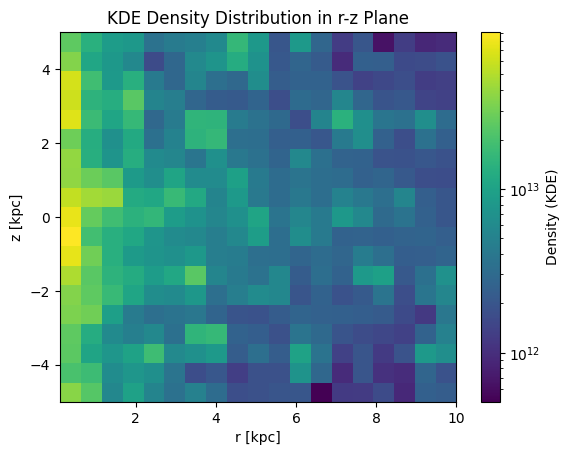

In [73]:
static_key = jax.random.PRNGKey(42)
density_kde2 = compute_kde_density_differentiable_final(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins, static_key)

plt.imshow(density_kde2.T, origin='lower', aspect='auto',
           extent=[0.1, 10, -5, 5], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density (KDE)')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('KDE Density Distribution in r-z Plane')
plt.show()

In [79]:
import jax
import jax.numpy as jnp

# Assume 'target_density' is a pre-calculated 2D array of the same shape as the output

def loss_fn(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins, nabla2_Phi, key):
    # 1. Compute the KDE density
    kde_density = compute_kde_density_differentiable_final(
        x, y, z, soft_weights, theta_spheroid, r_bins, z_bins, key
    )
    diff = (4*jnp.pi*G*kde_density - nabla2_Phi)
    # 2. Define a scalar loss (e.g., Mean Squared Error or L2 loss)
    # The sum of squared differences is a common, differentiable loss.
    loss = jnp.sum((diff)**2)
    
    return loss

In [80]:
# Create a dummy target density for testing (replace with your actual target)
# Assuming your r_bins and z_bins are the same size as defined before (20 bins -> 19x19 output)
r_size = len(r_bins) - 1
z_size = len(z_bins) - 1

# Set up fixed arguments (using a lambda function or `argnums` is essential)
# We choose to differentiate w.r.t the first argument, 'x' (argnums=0)
grad_x_fn = jax.grad(loss_fn, argnums=0)

# Compute the gradient
# You need to pass the actual arrays for x, y, z, etc., here.
# Assuming x, y, z, soft_weights, theta_spheroid, r_bins, z_bins are defined:
x_grad = grad_x_fn(x, y, z, soft_weights, theta_spheroid, r_bins, z_bins, nabla2_Phi, static_key)

In [81]:
import jax.numpy as jnp

# --- BEFORE calling loss_fn or grad_x_fn ---

# 1. Ensure all inputs for differentiation are JAX arrays
x_jnp = jnp.asarray(x, dtype=jnp.float64) 
y_jnp = jnp.asarray(y, dtype=jnp.float64)
z_jnp = jnp.asarray(z, dtype=jnp.float64)
soft_weights_jnp = jnp.asarray(soft_weights, dtype=jnp.float64) 
theta_spheroid_jnp = jnp.asarray(theta_spheroid, dtype=jnp.float64)
# Ensure target density is also a JAX float array
target_density_jnp = jnp.asarray(nabla2_Phi, dtype=jnp.float64)

# 2. Re-run the gradient calculation with the JAX arrays
grad_x_fn = jax.grad(loss_fn, argnums=0)
x_grad = grad_x_fn(x_jnp, y_jnp, z_jnp, soft_weights_jnp, theta_spheroid_jnp, r_bins, z_bins, target_density_jnp, static_key)

# 3. Check the maximum magnitude again
print(f"Maximum gradient magnitude (RERUN): {jnp.max(jnp.abs(x_grad))}")

/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_35385/2542941031.py:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  x_jnp = jnp.asarray(x, dtype=jnp.float64)
/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_35385/2542941031.py:7: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y_jnp = jnp.asarray(y, dtype=jnp.float64)
/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_35385/2542941031.py:8: UserWarning: Expli

Maximum gradient magnitude (RERUN): 7.457352293288405e+19


In [82]:
print(f"Shape of x_grad: {x_grad.shape}")
print(f"Total number of non-zero gradients in x: {jnp.sum(x_grad != 0)}")
print(f"Maximum gradient magnitude: {jnp.max(jnp.abs(x_grad))}")

# Final Check: Assert that the maximum gradient is above a small threshold
if jnp.max(jnp.abs(x_grad)) > 1e-8:
    print("\n✅ Gradient successfully computed and is non-zero (differentiability confirmed).")
else:
    print("\n❌ Gradient is zero or near-zero (differentiability may be compromised or loss is zero).")

Shape of x_grad: (500000,)
Total number of non-zero gradients in x: 408003
Maximum gradient magnitude: 7.457352293288405e+19

✅ Gradient successfully computed and is non-zero (differentiability confirmed).
